1. Import Libraries

cv2 → OpenCV library for computer vision tasks.

numpy → Handles array operations efficiently.

time → Measures inference duration.

psutil → Checks system memory usage before and after inference.

PIL (Pillow) + IPython.display → Used to display the final image nicely inside a Jupyter environment.

In [1]:
import cv2
import numpy as np
import time
import psutil
from IPython.display import display
from PIL import Image


2. Loading the YOLOv8 ONNX Model

Loads the YOLOv8 model in ONNX format.

cv2.dnn.readNet() is used to initialize the neural network model.

In [2]:
model_path = "yolov8n.onnx"
net = cv2.dnn.readNet(model_path)

3. Setting Up the Backend (GPU or CPU)

Tries to use the CUDA backend (NVIDIA GPU acceleration) for inference.

If CUDA is unavailable, falls back to CPU processing.

In [3]:
try:
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    print("Running on GPU (CUDA)")
except:
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
    print("CUDA not available. Running on CPU")

cv2.setUseOptimized(True)
cv2.setNumThreads(1)

Running on GPU (CUDA)


5. Loading COCO Class Names

Reads COCO dataset labels (e.g., "person", "car", "dog", etc.) from a text file.

These are used to label the detections.

In [4]:
with open("coco.names", "r") as f:
    class_names = [line.strip() for line in f.readlines()]

6. Letterbox Function – Image Preprocessing

- Resizes and pads the input image to match the YOLOv8 model’s input size (usually 640×640), while keeping the aspect ratio.

- Adds gray padding to avoid image distortion.

- Returns:

        - img_padded: the resized image with borders
        - ratio: scaling factor between original and resized image
        - dw, dh: padding offsets (used to reverse-map bounding boxes later)

In [5]:
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114)):
    #Resize and pad image while keeping aspect ratio.
    shape = img.shape[:2]  # height, width
    ratio = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    new_unpad = (int(shape[1] * ratio), int(shape[0] * ratio))
    dw = new_shape[1] - new_unpad[0]
    dh = new_shape[0] - new_unpad[1]
    dw /= 2
    dh /= 2

    img_resized = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh)), int(round(dh))
    left, right = int(round(dw)), int(round(dw))
    img_padded = cv2.copyMakeBorder(
        img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )
    return img_padded, ratio, left, top

7. Object Detection Function

- Memory and time measurement: Tracks resource usage for analysis.
- Preprocessing: Applies letterbox resizing and creates a blob using cv2.dnn.blobFromImage().

        - Normalizes pixels to [0,1] with 1/255.0.
        - Swaps R and B channels (swapRB=True) because OpenCV uses BGR format by default.
        
- Inference: net.forward() runs the YOLOv8 model on the preprocessed image.
- YOLOv8 outputs a large tensor containing bounding box predictions, confidence scores, and class probabilities.

In [6]:
def detect_objects(frame, display_width=800):
    input_size = 640

    # Measure start memory & time
    process = psutil.Process()
    mem_before = process.memory_info().rss / (1024 ** 2)
    start_time = time.time()

    # Preprocess
    img_letterboxed, ratio, dw, dh = letterbox(frame, new_shape=(input_size, input_size))
    blob = cv2.dnn.blobFromImage(
        img_letterboxed, 1/255.0, (input_size, input_size), swapRB=True, crop=False
    )
    net.setInput(blob)

    # Inference
    outputs = net.forward()

    # Measure end time & memory
    end_time = time.time()
    mem_after = process.memory_info().rss / (1024 ** 2)
    inference_time = end_time - start_time
    mem_used = mem_after - mem_before

    # Post-processing
    H, W, _ = frame.shape
    boxes, confidences, class_ids = [], [], []

    # Handle output shape variations
    if len(outputs.shape) == 3 and outputs.shape[1] == 25200 and outputs.shape[2] == 85:
        output = outputs[0]
    elif len(outputs.shape) == 3 and outputs.shape[1] == 84 and outputs.shape[2] == 8400:
        output = outputs[0].T
    elif len(outputs.shape) == 3 and outputs.shape[1] == 8400 and outputs.shape[2] == 85:
        output = outputs[0]
    else:
        raise ValueError(f"Unexpected output shape: {outputs.shape}")

    for detection in output:
        if output.shape[1] == 85:
            scores = detection[5:]
            objectness = detection[4]
            class_id = np.argmax(scores)
            confidence = objectness * scores[class_id]
        elif output.shape[1] == 84:
            scores = detection[4:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
        else:
            continue

        if confidence > 0.3:
            cx, cy, w, h = detection[0:4]
            cx *= input_size
            cy *= input_size
            w *= input_size
            h *= input_size

            x = int((cx - w / 2 - dw) / ratio)
            y = int((cy - h / 2 - dh) / ratio)
            w = int(w / ratio)
            h = int(h / ratio)

            x = max(0, x)
            y = max(0, y)
            w = min(W - x, w)
            h = min(H - y, h)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

    # Apply Non-Maximum Suppression (NMS)
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.4)

    if len(indices) > 0:
        # Draw Boxes and Labels with white background + larger text
        for i in indices.flatten():
            x, y, w, h = boxes[i]
            label = class_names[class_ids[i]]
            confidence = confidences[i]
            color = (0, 255, 0)

            # Text setup
            label_text = f"{label} {confidence:.2f}"
            font_scale = 2.0
            font_thickness = 3

            # Get text size
            (text_width, text_height), baseline = cv2.getTextSize(
                label_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness
            )

            # Position text above box
            text_x = x
            text_y = y - 10
            if text_y < text_height:
                text_y = y + h + text_height + 10  # move below if near top

            # Draw white background rectangle
            cv2.rectangle(
                frame,
                (text_x, text_y - text_height - baseline),
                (text_x + text_width, text_y + baseline),
                (255, 255, 255),
                cv2.FILLED
            )

            # Draw black text on white background
            cv2.putText(
                frame, label_text, (text_x, text_y),
                cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness
            )

            # Draw bounding box
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 4)

    # Print performance stats
    print(f" Inference Time: {inference_time:.3f} seconds")
    print(f" Memory Used: {mem_used:.3f} MB")

    # Resize for display (maintain aspect ratio)
    h, w = frame.shape[:2]
    scale = display_width / w
    display_height = int(h * scale)
    resized_frame = cv2.resize(frame, (display_width, display_height))

    return resized_frame


8. Run Detecion on image

Example 1:

Processing: image1.jpg
 Inference Time: 0.215 seconds
 Memory Used: 358.297 MB
Displaying result for image1.jpg


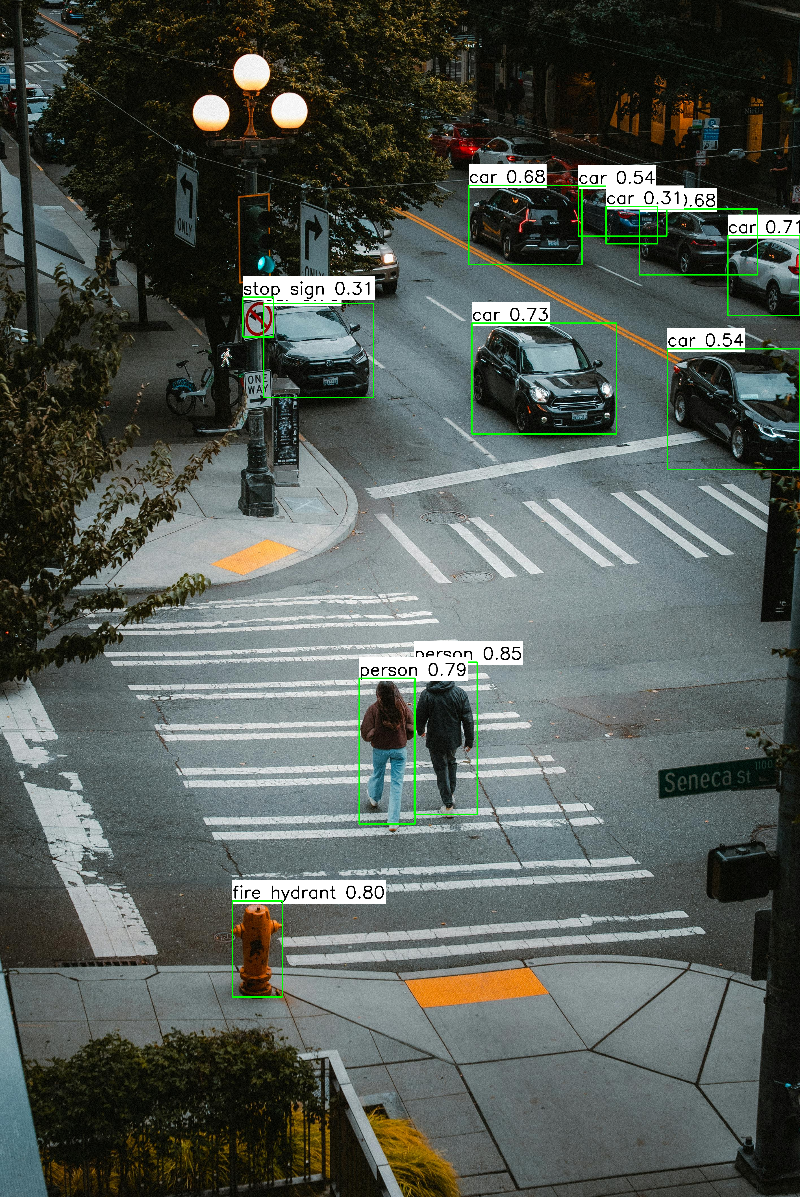

In [7]:
def show_image(img):
    display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

# Detect and show
image_path = "image1.jpg"
image = cv2.imread(image_path)

if image is None:
    print("Error: Image not found or unable to read.")
else:
    print(f"Processing: {image_path}")
    result = detect_objects(image, display_width=800)
    print(f"Displaying result for {image_path}")
    show_image(result)


Example 2:

Processing: image2.jpg
 Inference Time: 0.007 seconds
 Memory Used: 0.000 MB
Displaying result for image2.jpg


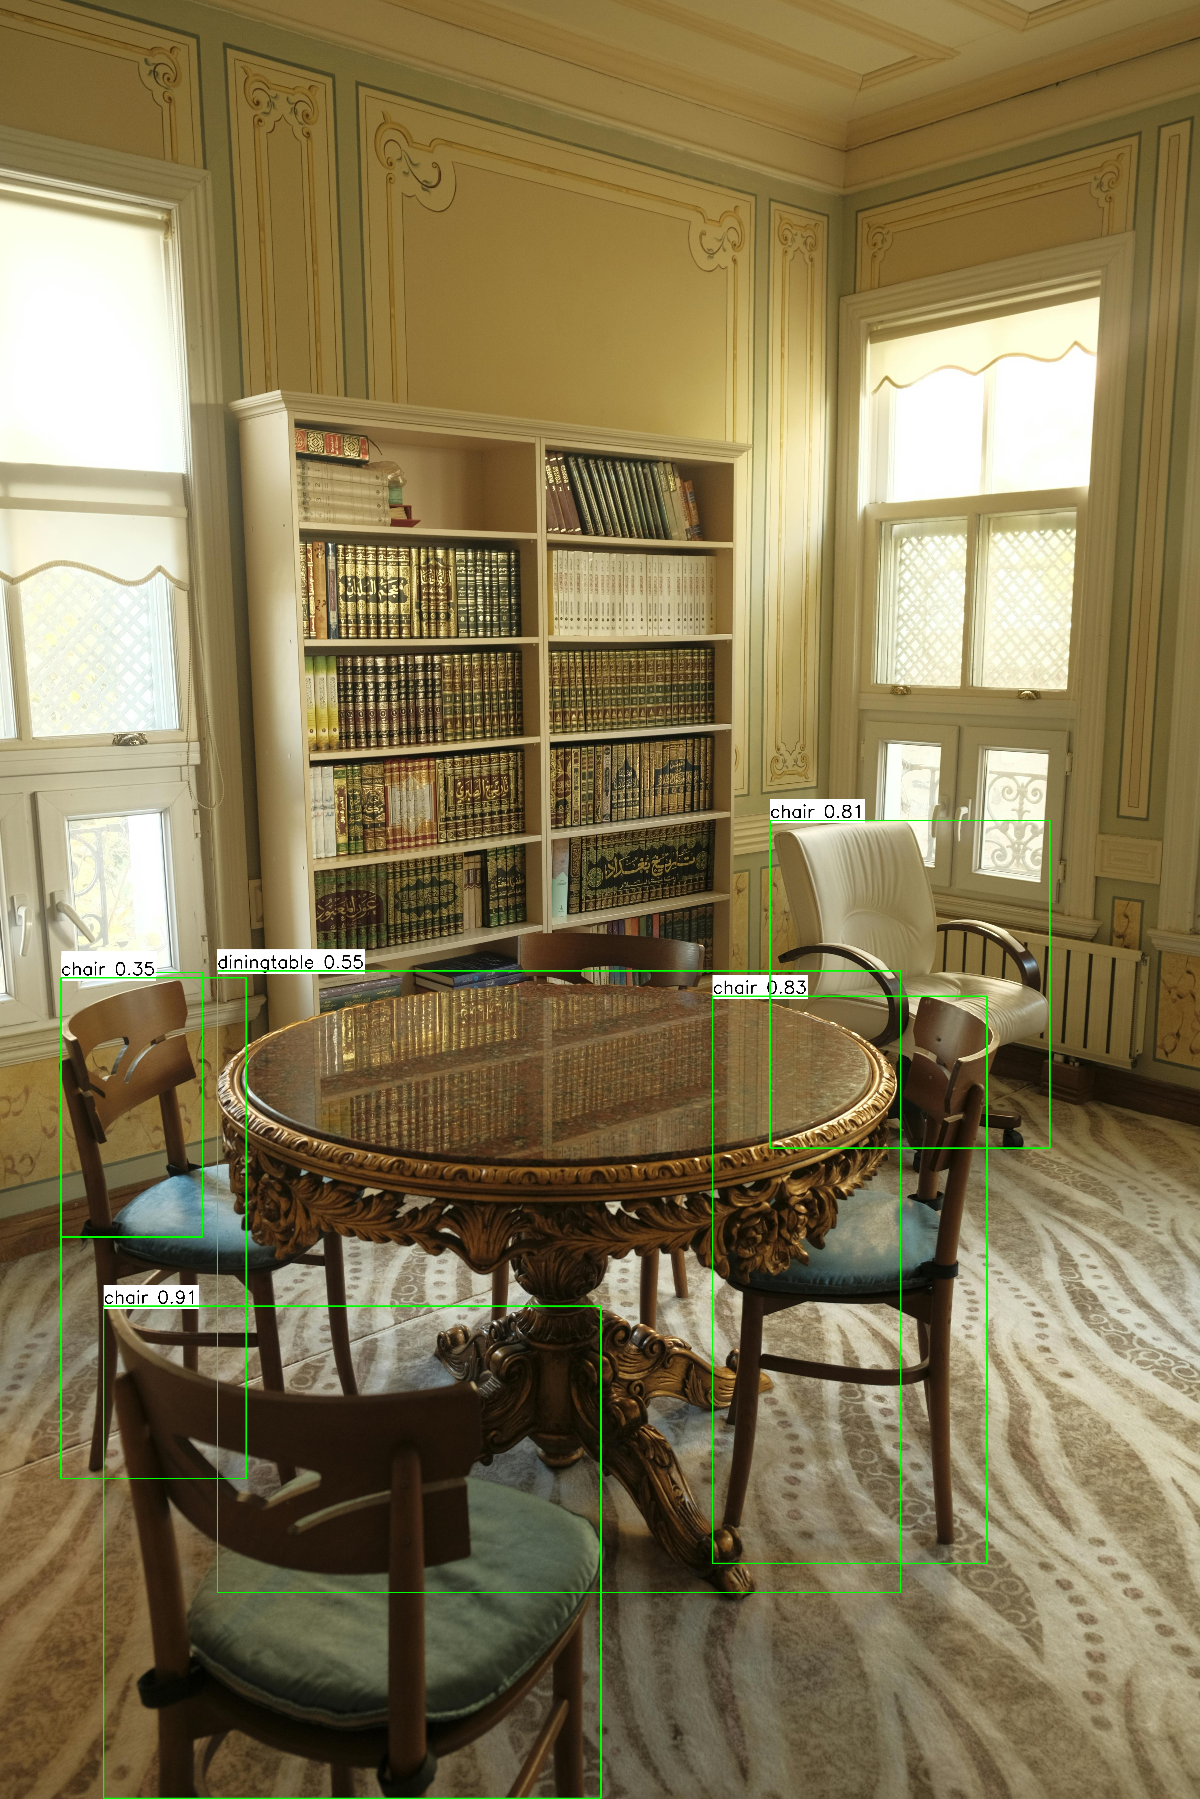

In [8]:
def show_image(img):
    display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

# Detect and show
image_path = "image2.jpg"
image = cv2.imread(image_path)

if image is None:
    print("Error: Image not found or unable to read.")
else:
    print(f"Processing: {image_path}")
    result = detect_objects(image, display_width=1200)
    print(f"Displaying result for {image_path}")
    show_image(result)
